In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [2]:
# 1. Load and Visualize the Data
data = pd.read_excel("Gold_price_gbp.xlsx",index_col="Date", parse_dates=True)
prices = data['GBP'].values

In [3]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))


In [4]:
# Define a function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length + 1])
    return np.array(sequences)

sequence_length = 10  # Choose your sequence length
sequences = create_sequences(prices_scaled, sequence_length)


In [5]:
# Split data into features and labels
X = sequences[:, :-1]
y = sequences[:, -1]

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [6]:
# Reshape data for CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [7]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
296/296 [==============================] - 2s 3ms/step - loss: 0.0021 - val_loss: 5.6695e-04
Epoch 2/50
296/296 [==============================] - 1s 2ms/step - loss: 5.2786e-04 - val_loss: 4.7180e-04
Epoch 3/50
296/296 [==============================] - 1s 2ms/step - loss: 4.6969e-04 - val_loss: 1.7526e-04
Epoch 4/50
296/296 [==============================] - 1s 2ms/step - loss: 4.3664e-04 - val_loss: 1.6936e-04
Epoch 5/50
296/296 [==============================] - 1s 2ms/step - loss: 4.3592e-04 - val_loss: 0.0011
Epoch 6/50
296/296 [==============================] - 1s 2ms/step - loss: 4.1461e-04 - val_loss: 3.0858e-04
Epoch 7/50
296/296 [==============================] - 1s 2ms/step - loss: 4.2006e-04 - val_loss: 1.9242e-04
Epoch 8/50
296/296 [==============================] - 1s 2ms/step - loss: 4.1794e-04 - val_loss: 8.3886e-04
Epoch 9/50
296/296 [==============================] - 1s 2ms/step - loss: 4.0568e-04 - val_loss: 0.0015
Epoch 10/50
296/296 [===================

In [8]:
# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform the training set for plotting
y_train_scaled = model.predict(X_train)
y_train_inv = scaler.inverse_transform(y_train_scaled)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))


296/296 [==============================] - 0s 1ms/step


In [9]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
smape = np.mean(np.abs(y_test_actual - y_pred) / ((np.abs(y_test_actual) + np.abs(y_pred)) / 2)) * 100
mase = mae / np.mean(np.abs(np.diff(y_test_actual.flatten())))
r2 = r2_score(y_test_actual, y_pred)

# Print evaluation metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'sMAPE: {smape}')
print(f'MASE: {mase}')
print(f'R2: {r2}')

MAE: 21.169375258185937
MSE: 746.085580832779
RMSE: 27.3145671910206
MAPE: 1.7539007489805716
sMAPE: 1.7337939029344878
MASE: 2.7246007446194174
R2: 0.990444942814659


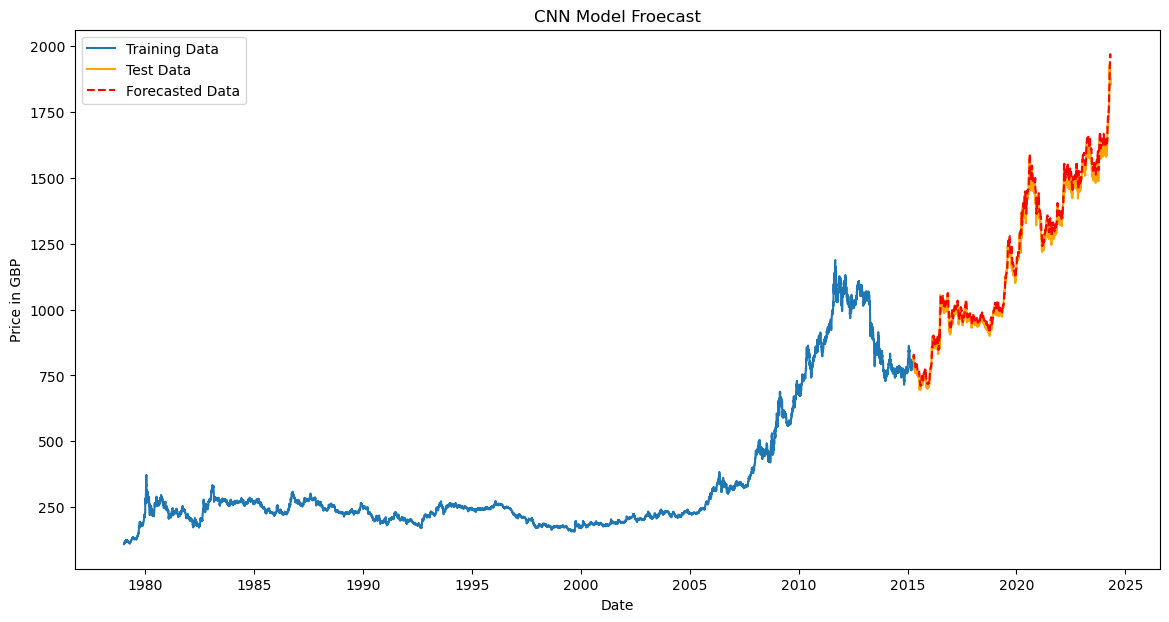

In [14]:
# Plot actual vs predicted prices including training data
plt.figure(figsize=(14, 7))
plt.plot(data.index[sequence_length:train_size + sequence_length], y_train_actual, label='Training Data')
#plt.plot(data.index[sequence_length:train_size + sequence_length], y_train_inv, label='Train Predicted')
plt.plot(data.index[train_size + sequence_length:], y_test_actual, label='Test Data', color='orange')
plt.plot(data.index[train_size + sequence_length:], y_pred, label='Forecasted Data', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Price in GBP')
plt.title('CNN Model Froecast')
plt.legend()
plt.show()